# Abstract

This blog utilizes the Palmer Penguins dataset to develop predictive models for determining the species of penguins based on their morphological measurements. The dataset comprises various features, including culmen length and depth, flipper length, and body mass, across three species: Adelie, Chinstrap, and Gentoo. Qualitative features such as Island, Clutch Completion, and Sex are also included. Through visual analysis, features which differed between species were identified and selected for model training. Both Logistic Regression and Decision Trees (not shown) were implemented and evaluated. Model performance was assessed using training accuracy both absolute and through cross validation as well as assessment on separate testing data.

# Data Preparation and Feature Selection

Loading neccesary packages and prepping the Palmer Penquins data.

In [39]:
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
df = pd.read_csv(url)

# Shorten the species name
df["Species"] = df["Species"].str.split().str.get(0)

# filter our data so it only contains the variables we will look at first
# look at the first 5 entries to determine variables that seem as if they could have a correlation
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


In [40]:
df.groupby(["Island", "Species"]).size()

Island     Species  
Biscoe     Adelie       33
           Gentoo       98
Dream      Adelie       45
           Chinstrap    57
Torgersen  Adelie       42
dtype: int64

Torgersen Island is home exclusively to Adelie penguins, while Dream Island is the only habitat for Chinstrap penguins, despite an almost equal distribution of Adelie and Chinstrap there. Biscoe Island hosts primarily Gentoo penguins, making up 74.8% of its population. While Adelie penguins are found on all islands, each island has a degree of exclusivity in species distribution.

Lets look at the three quantitative predictor variables and plot the combinations we can make.

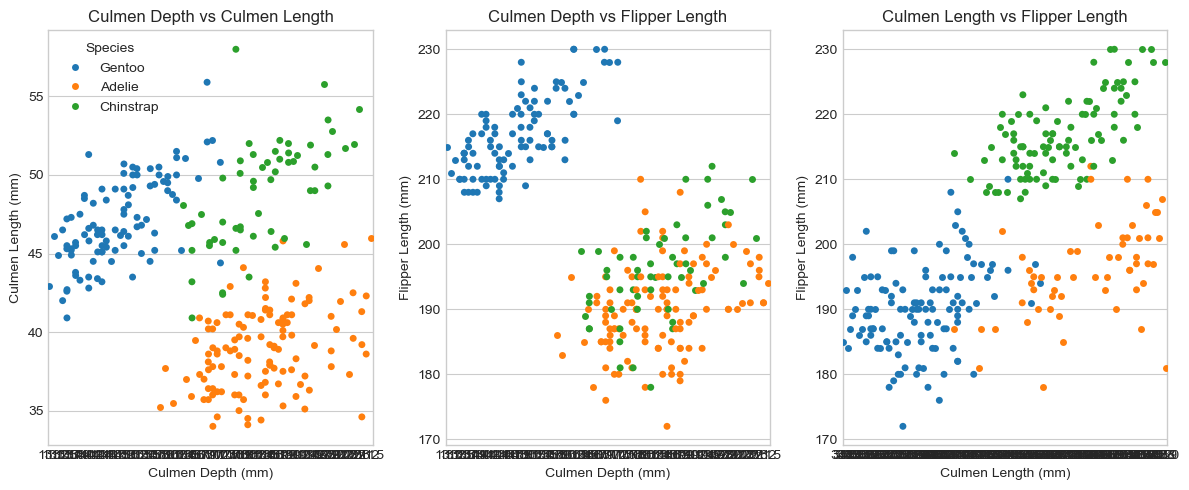

In [41]:
# explore the species groups by culmen length
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.stripplot(x = "Culmen Depth (mm)", y = "Culmen Length (mm)", data = df, hue = "Species", ax = axes[0], dodge = True)
axes[0].set_title("Culmen Depth vs Culmen Length")

sns.stripplot(x = "Culmen Depth (mm)", y = "Flipper Length (mm)", data = df, hue = "Species", ax = axes[1], dodge = True, legend = False)
axes[1].set_title("Culmen Depth vs Flipper Length")

sns.stripplot(x = "Culmen Length (mm)", y = "Flipper Length (mm)", data = df, hue = "Species", ax = axes[2], dodge = True, legend = False)
axes[2].set_title("Culmen Length vs Flipper Length")

plt.tight_layout()
plt.show()

While Culmen Depth vs Flipper Length provides the clearest specification for Gentoo Penguins, Adelie and Chinstrap become too muddled to properly distinguish. Culmen Length vs Flipper Length does a good job in making three clusters, with Chinstrap isolating the most, howeever there is still overlap in the regions of Gentoo and Adelie. Culmen Depth vs Culmen Length provides the three most visually distinct clusters for each Penquin species while minimizes visual overlap. Thus, Culmen Depth vs Culme Length will serve as the best choice for quanitative predictors. 

Next we will define a method to properly give integer values to species as well as other categorical variables and apply this method to our data. 

In [42]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for categorical variables
le = LabelEncoder()
le.fit(df["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

# Prepare data
df_train, y_train = prepare_data(df)

# Visualize our new training data
df_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


With our new training data lets prepare a new data frame only including the predictors we want. 

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier

# Select the columns we want and separate into predictors
predictor_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Biscoe", "Island_Torgersen", "Island_Dream"]

X_train = df_train[predictor_cols]
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Island_Biscoe,Island_Torgersen,Island_Dream
0,40.9,16.6,False,False,True
1,49.0,19.5,False,False,True
2,50.0,15.2,True,False,False
3,45.8,14.6,True,False,False
4,51.0,18.8,False,False,True


# Fitting a Model

Fitting a Linear Regression ML model.

In [44]:
LR = LogisticRegression(max_iter = 10000)
m = LR.fit(X_train, y_train)

Time to check the training accuracy of the model and cross validate as well as pre-process the testing data for later use. 

In [45]:
from sklearn.model_selection import cross_val_score

# load the testing data to check the accuracy of our model
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"] = test["Species"].str.split().str.get(0)

# prep the testing data for later use
X_test, y_test = prepare_data(test)
X_test1 = X_test[predictor_cols]

print("Linear Regression for dataset 1 has a training accuracy of : " + str(LR.score(X_train, y_train)))

cv_scores_LR = cross_val_score(LR, X_train, y_train, cv = 5)
print("And cross validation scores: " + str(cv_scores_LR))


Linear Regression for dataset 1 has a training accuracy of : 0.99609375
And cross validation scores: [0.981 1.    1.    0.961 1.   ]


The model has high training accuracy which is confirmed via cross validation. Next we will plot the decision regions for the model against the training data.

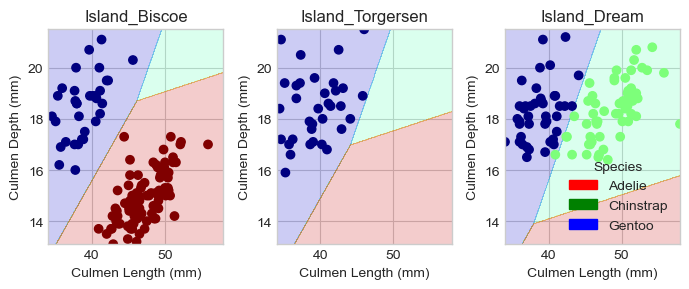

In [46]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

plot_regions(LR, X_train, y_train)

The model seems to be making reasonable decisions for classiying Penquin species on each island. The only island in which the model does not make perfect decisions, is Dream island which is home to all species of Penquins. Next, assess the model against the testing data. 

In [47]:
# Check the model accuracy against the testing data
print("Linear Regression for dataset 1 has testing accuracy of: " + str(LR.score(X_test1, y_test)))

Linear Regression for dataset 1 has testing accuracy of: 1.0


100% testing accuracy has been achieved with a Linear Regression model for classifying Penquin Species. Lets view the confusion matrix for our succesfull model as well as look at the decision regions for the model evaluated on the test set. 

Confusion Matrix For the Model:
[[31  0  0]
 [ 0 11  0]
 [ 0  0 26]]


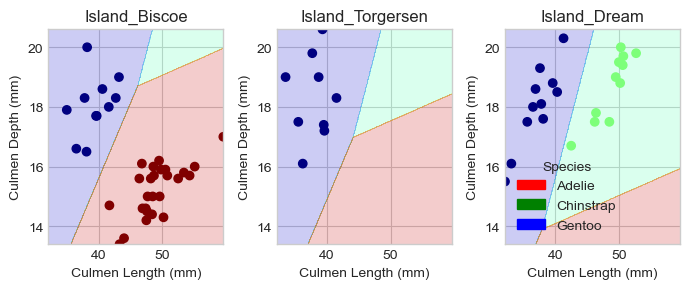

In [49]:
from sklearn.metrics import confusion_matrix

y_test_pred = LR.predict(X_test1)
C = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix For the Model:\n" + str(C))

plot_regions(LR, X_test1, y_test)

100% accuracy has been achieved! We have now developed a model with 100% testing accuracy for identifying Palmer Penquins based on physiologcal characteristics. By plotting the decision regions versus the test data and by looking at the confusion matrix, it becomes clear that the model was able to distinguish every penquin soley based on the provided information. If you ran this code yourself and did not achieve 100% accuracy on one of these models, re-run the code with new training and testing data (this will produce a model with 100% testing accuracy after 2 - 3 tries if not on the first). Since it was mentioned above, lets run the DecisionTreeClassifiers for fun. 

# Discussion

Through the process of analyzing the Palmer Penguins dataset, several key insights were uncovered regarding the classification of penguin species based on their physical characteristics. First, identifying the quantitative features which created the clearest three groupings was key. In fact, more time should have been spent in the beginning graphing out possible combinations of quantitative features; this process may have more quickly identified Culmen Length and Depth as the best features for clustering penquin species together. Plotting tables for the qualitative features also proved key, as it quickly identified that Island was a good indicator of species. In addition, when dealing with models such as the DecisionTreeClassifier (not shown in this post) utilizing cross validation as a check for overfitting helped identify the correct depth range for our models, as lower values procuded worse testing accuracy, but the extremely high complexity values produced overfitted results. Finally, as a general note, I would spend more time in the beginning exploring potential data combinations via graphical methods in order to more quickly identify the predicators which might work best rather than plug and chug; I did, however, enjoy the process of tinkering with the different models and datasets until I found the perfect one. 